Para baixar todos os nossos experimentos, use estes links:

https://drive.google.com/open?id=1WiyXsCDwH1Cm_0_bGHuywHPqj4GmI4l4

https://drive.google.com/open?id=1371AETlvjBL5BYs5qc9TaYhx6iVNBOoT

# Primeiro, vamos definir uma série de funções para facilitar a apresentação
- Essas funções eram blocos de código nos notebooks classifier_DCGAN_review e WGAN
- O intuito de agrupar todo o cógigo em uma função main foi facilitar a apresentação

# Imports

In [1]:
import os
import time
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
import matplotlib.gridspec as gridspec

## Setando corretamente as GPU's

In [2]:
def set_cuda(TARGET_GPU=None):
    '''
    Prompts relevant package versions.
    Verifies if system has GPU enabled and returns this status.
    Can be used to set what GPUs are visible by current process.
    '''
    print('__Python VERSION:', sys.version)
    print('__pyTorch VERSION:', torch.__version__)
    print('__CUDA VERSION')
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__Devices')
    print('Active CUDA Device: GPU', torch.cuda.current_device())
    
    cudnn.benchmark = True

    if torch.cuda.device_count() > 1 and TARGET_GPU is not None:
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = str(TARGET_GPU)
        print("You have manually set configured the visible GPUs. Now only GPUs {} will be visible. Make sure you know what you are doing.".format(TARGET_GPU))
        
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        print("You are using CUDA. If it is not what you want, manually set this as False!")
        
    return(use_gpu)

# Definindo o Dataset

### Dataset definition and hyperparameter setting
- Changing dataset name alters network architecture parameters
- Currently supporting few datasets
- Hyperparameters defined according to Radford et al. (2015)

In [3]:
def define_dataset(chosen_dataset):
    datasets = {
        'MNIST': torchvision.datasets.MNIST,
        'CIFAR10': torchvision.datasets.CIFAR10,
        'ANIME': '/home/gabriel/Redes Neurais/Projeto_Final_GANS/Tutorial_2/dataset/min_anime-faces',
    }
    dataset = datasets[chosen_dataset]

    possible_parameters = {
        'MNIST': {
            'ndf': 64,
            'ngf': 64,
            'nz': 100,
            'nc': 1,
            'imageSize': 64,
            'n_classes': 10,
        },
        'CIFAR10': {
            'ndf': 64,
            'ngf': 64,
            'nz': 100,
            'nc': 3,
            'imageSize': 64,
            'n_classes': 10,
        },
        'ANIME': {
            'nc': 3,
            'nz': 100,
            'ngf': 64,
            'ndf': 64,
            'imageSize': 64,
            'n_classes': 1
        }
    }

    ngf = possible_parameters[chosen_dataset]['ngf']
    ndf = possible_parameters[chosen_dataset]['ndf']
    nz = possible_parameters[chosen_dataset]['nz']
    nc = possible_parameters[chosen_dataset]['nc']
    imageSize = possible_parameters[chosen_dataset]['imageSize']
    n_classes = possible_parameters[chosen_dataset]['n_classes']

    if dataset == 'ANIME':
        dataset = torchvision.datasets.ImageFolder(
            root='/home/gabriel/Redes Neurais/Projeto_Final_GANS/Tutorial_2/dataset/min_anime-faces',
            transform=transforms.Compose([
                transforms.Scale((imageSize, imageSize)),
                transforms.ToTensor(),
            ])
        )
    else:
        transform = transforms.Compose([
            transforms.Scale((imageSize, imageSize)),
            transforms.ToTensor(),
            # bring images to (-1,1)
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        dataset_done = dataset('./datasets', train=True, download=True, transform=transform)
        
    return(dataset_done, ngf, ndf, nz, nc, imageSize, n_classes)


# Definindo o Dataloader

In [4]:
def define_dataloader(dataset_done, batch_size):
    dataloader = torch.utils.data.DataLoader(dataset_done, batch_size=batch_size,
                                             shuffle=True, num_workers=4)
    
    print("Dataset:", dataloader.dataset)
    print('Dataloader length:', len(dataloader))
    return(dataloader)

# Definição da rede classificadora

In [5]:
class _netD_DCGAN(nn.Module):
    def __init__(self, nz, nc, ndf, n_classes):
        super(_netD_DCGAN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=nc, out_channels=ndf,
                               kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=ndf, out_channels=ndf * 2,
                               kernel_size=4, stride=2, padding=1, bias=False)
        self.batch2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4,
                               kernel_size=4, stride=2, padding=1, bias=False)
        self.batch3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8,
                               kernel_size=4, stride=2, padding=1, bias=False)
        self.batch4 = nn.BatchNorm2d(ndf * 8)

        self.final_conv = nn.Conv2d(
            in_channels=ndf * 8, out_channels=n_classes + 1, kernel_size=4, stride=1, padding=0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, inplace=True)
        x = F.leaky_relu(self.batch2(self.conv2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.batch3(self.conv3(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.batch4(self.conv4(x)), 0.2, inplace=True)

        x = self.final_conv(x)
        return(x)


# Definição da rede geradora

In [6]:
class _netG_DCGAN(nn.Module):
    def __init__(self, nz, nc, ngf):
        super(_netG_DCGAN, self).__init__()
        self.convt1 = nn.ConvTranspose2d(
            in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False)
        self.batch1 = nn.BatchNorm2d(ngf * 8)
        self.convt2 = nn.ConvTranspose2d(
            in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch2 = nn.BatchNorm2d(ngf * 4)
        self.convt3 = nn.ConvTranspose2d(
            in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch3 = nn.BatchNorm2d(ngf * 2)
        self.convt4 = nn.ConvTranspose2d(
            in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch4 = nn.BatchNorm2d(ngf)

        self.final_convt = nn.ConvTranspose2d(
            in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.batch1(self.convt1(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.batch2(self.convt2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.batch3(self.convt3(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.batch4(self.convt4(x)), 0.2, inplace=True)

        x = self.final_convt(x)
        x = F.tanh(x)
        return (x)

# Inicializador de pesos
- Pesos de camadas convolucionais são inicializados com gaussiana de média 0 e desvio padrão 0.02
- Pesos de camadas BatchNorm são inicializados com gaussiana de média 1 e desvio padrão 0.02

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Inicializador de tensores

In [8]:
def initialize_tensors(batch_size, nc, imageSize, nz, n_classes):
    input = torch.FloatTensor(batch_size, nc, imageSize, imageSize)
    print('Input images size:', input.size())
    
    noise = torch.FloatTensor(batch_size, nz, 1, 1)
    fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
    print('Code size:', noise.size())

    label = torch.LongTensor(batch_size, n_classes)
    print('Label size:', label.size())
    fake_label = 10
    return(input, noise, fixed_noise, label, fake_label)

# Fazendo Broadcast para a GPU

In [9]:
def broadcast_to_gpu(use_gpu, netD, netG, label, input, criterion, fixed_noise, noise):
    if use_gpu:
        print('Broadcasting to the GPU...')
        netD.cuda()
        netG.cuda()
        criterion = criterion.cuda()
        input, label = input.cuda(), label.cuda()
        noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
    else:
        print("GPU isn't available ")

# Definindo as propriedades do otimizador e função de custo

In [10]:
def optimization_properties(netD, netG, lr, beta1, beta2):
    criterion = nn.CrossEntropyLoss()

    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))
    return(optimizerG, optimizerD, criterion)

# Função para salvar as imagens

In [11]:
def save_images(netG, fixed_noise, epoch, imageSize, outputDir):
    fixed_noise = Variable(fixed_noise)
    netG.eval()
    fake_data = netG(fixed_noise.cuda())
    netG.train()
    plt.savefig(outputDir + '/dcgan_img_{:04d}.png'.format(epoch, bbox_inches='tight'))
    plt.close(fig)

# Função que salva os modelos

In [12]:
def save_models(netG, netD, outputDir, epoch):
    '''
    Saves model state dictionary for generator and discriminator networks.
    Inputs are the networks (netG, netD), the system path in which to save(outputDir) and the current 'epoch'.
    '''
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outputDir, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outputDir, epoch))

# Função que define o diretório de saída
- Cria diretório onde imagens serão salvas

In [13]:
def define_outputDir(outputDir):
    try:
        os.makedirs(outputDir)
        print('Directory created!')
    except OSError as err:
        print("OS error: {0}".format(err))
    return(outputDir)

# Função que carrega os modelos 

In [14]:
def load_models(netG, netD, outputDir, epoch):
    '''
    Saves( model state dictionary for generator and discriminator networks.
    Inputs are the networks (netG, netD), the system path in which to save(outputDir) and the current 'epoch'.
    '''
    #model.load_state_dict(torch.load('mytraining.pt'))
    netG.load_state_dict(torch.load('%s/netG_epoch_%d.pth' % (outputDir, epoch)))
    netD.load_state_dict(torch.load('%s/netD_epoch_%d.pth' % (outputDir, epoch)))


# Função de treinamento e algoritmo da nossa aplicação
- Modelo DCGAN. WGAN requer algumas pequenas modificações no laço de treinamento

In [15]:
def train_gan(num_epochs, dataloader, netD, optimizerD, netG, optimizerG, criterion, nz, outputDir, noise, fixed_noise, imageSize,
              real_labelSmooth=0, epoch_interval=100, D_steps=1, G_steps=1, fake_label=0, n_classes=10, LS_decay=0.05):

    # This validation is subjective. WGAN-GP uses 100 steps on the critic (netD).
    assert D_steps < 5, "Keep it low, D_steps is too high."
    assert G_steps < 3, "Keep it low, G_steps is too high."
    #assert batch_size % D_steps == 0, "Use batch_size multiple of D_steps."
    real_label = 1
    print('Lets train!')
    for epoch in range(num_epochs):
        start_iter = time.time()
        D_x = 0
        D_G_z1 = 0
        D_G_z2 = 0
        errD_acum = 0
        errG_acum = 0

        real_labelSmooth = np.maximum(real_labelSmooth * (1 - LS_decay * epoch), 0)
        
        print('In epoch = ', epoch, 'real_label_smooth = ', real_labelSmooth)
        for batch, data in enumerate(dataloader, 0):                
            for step in range(D_steps):
                #############################################################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                # 1A - Train the detective network in the Real Dataset
                #############################################################
                netD.zero_grad()
                start = step * (int(data[0].size()[0] / D_steps))
                end = (step + 1) * int(data[0].size()[0] / D_steps)

                real_cpu = data[0][start:end]
                real_cpu = real_cpu.cuda()
                batch_size = real_cpu.size(0)
                
                if np.random.random_sample() > real_labelSmooth:
                    target = data[1][start:end].long().cuda()
                else:
                    target = torch.from_numpy(np.random.randint(0, n_classes, batch_size)).type(torch.LongTensor).cuda()

                input, label = Variable(real_cpu), Variable(target)

                output = netD(input)
                errD_real = criterion(output.squeeze(), label)
                errD_real.backward()

                D_x += output.data.mean()

                #######################################################
                # 1B - Train the detective network in the False Dataset
                #######################################################

                noise = Variable(torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1).cuda())
                fake = netG(noise)
                label = Variable(torch.ones(batch_size).long().fill_(fake_label).cuda())
                # ".detach()" to avoid backprop through G
                output = netD(fake.detach())
                errD_fake = criterion(output.squeeze(), label)
                errD_fake.backward()  # gradients for fake and real data will be accumulated

                D_G_z1 += output.data.mean()
                errD_acum += errD_real.data[0] + errD_fake.data[0]
                optimizerD.step()

            for step in range(G_steps):
                ####################################################################################
                # (2) Update G network: maximize log(D(G(z)))
                # Train the faker with the output from the Detective (but don't train the Detective)
                ####################################################################################

                netG.zero_grad()
                label = Variable(torch.from_numpy(np.random.randint(0, n_classes, batch_size)).type(torch.LongTensor).cuda())
                output = netD(fake)
                errG = criterion(output.squeeze(), label)
                errG.backward()

                D_G_z2 += output.data.mean()
                errG_acum += errG.data[0]
                optimizerG.step()

        print('epoch = ', epoch)

        end_iter = time.time()

        print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f Elapsed %.2f s'
              % (epoch, num_epochs, errD_acum / D_steps, errG_acum / G_steps, D_x, D_G_z1, D_G_z2, end_iter - start_iter))

        # Save a grid with the pictures from the dataset, up until 64
        save_images(netG, fixed_noise, epoch,
                    imageSize=imageSize, outputDir=outputDir)

        if epoch % epoch_interval == 0:
            # do checkpointing
            save_models(netG=netG, netD=netD, outputDir=outputDir, epoch=epoch)


# Afinal, o que são GANs?

- Framework de geração adversarial proposto em [Goodfellow et. al., 2014](https://arxiv.org/abs/1406.2661) não especifica qual o tipo do gerador e do discriminador.
- Usar redes neurais para as duas partes desse problema é conveniente: backpropagation e algoritmos de otimização viabilizam treinamento das duas redes simultaneamente. Esse caso especial recebe o nome de Generative Adversarial Nets.
- Esse caso especial apresenta a vantagem de que todos os desenvolvimentos dos campos de Deep Learning podem ser explorados sem grandes impedimentos (BN, Dropout, otimizadores, ativações, arquiteturas)

## Qual a cara desse framework?

<img src='apresentacao_imagens/GAN_layout0.png', width=750pt>
<img src='apresentacao_imagens/GAN_layout1.png', width=750pt>
<img src='apresentacao_imagens/GAN_layout2.png', width=750pt>
<img src='apresentacao_imagens/GAN_layout3.png', width=750pt>

## Variações

- Encoder-Decoder GANs [[ref]](https://arxiv.org/abs/1511.06434)
- Arquiteturas GAN + VAE [[ref]](https://arxiv.org/abs/1703.00848v4)
- Arquiteturas com 3 blocos funcionais [[ref]](https://arxiv.org/abs/1703.02291)

# Problemas

- Convergência não é garantida (e é muito díficil em algumas condições)

    1. Modelos são muito sensíveis aos hiperparâmetros utilizados (alto custo de busca por hiperparâmetros dificulta o treinamento de GANs tradicionais);

    2. Técnicas para facilitar convergência geram problemas secundários e ainda não há um padrão bem definido quanto a boas práticas;
    
    
    

- Mesmo quando modelo converge, podem acontecer problemas...

    1. Mode Collapse

    2. Convergência para mínimos locais

## Sensibilidade
- Resultados abaixo são para LS_decay=0.025, epoch=40, variando labelSmooth em 0.05 [0.1, 0.15, 0.2]

<tr>
    <td><img src='apresentacao_imagens/smooth_0d10_decay_0d025_epoch_40.jpeg', width=330pt></td>
    <td><img src='apresentacao_imagens/smooth_0d15_decay_0d025_epoch_40.jpeg', width=330pt></td>
    <td><img src='apresentacao_imagens/smooth_0d20_decay_0d025_epoch_40.jpeg', width=330pt></td>
</tr>

## Divergência

<tr>
    <td><img src='apresentacao_imagens/smooth_0d10_decay_0d05_epoch_1.png', width=330pt></td>
    <td><img src='apresentacao_imagens/smooth_0d10_decay_0d05_epoch_10.png', width=330pt></td>
    <td><img src='apresentacao_imagens/smooth_0d10_decay_0d05_epoch_25.png', width=330pt></td>
</tr>

### Mode Collapse?
Modos mal representados, dataset pequeno ou hiperparâmetros longe do ideal podem gerar condições em que grande parte do código é traduzida para uma mesma imagem que engana bastante o discriminador, mas é longe do desejado

<tr>
    <td><img src='apresentacao_imagens/mode_collapse01.jpeg', width=330pt></td>
    <td><img src='apresentacao_imagens/mode_collapse02.jpeg', width=330pt></td>
    <td><img src='apresentacao_imagens/mode_collapse03.jpeg', width=330pt></td>
</tr>

# Passos em direção à convergência

1) DC-GAN

2) Label Smoothing para os rótulos reais

3) Utilização de rótulos de classes

4) Alteração das funções de custo 

    a) EBGAN, WGAN, CramerGAN, WGAN-GP, WGAN-LP…

    b) Feature Selection Strikes Back

# DCGAN

1) Proposta em [Radford et. al., 2015](https://arxiv.org/abs/1511.06434), trata-se de uma arquitetura de rede totalmente convolucional cuidadosamente escolhida 

2) Apresenta convergência mais garantida e menor sensibilidade a hiperparâmetros

3) Proporciona um modelo base sobre o qual iterar e uma boa referência de desempenho: quase todas as arquiteturas são comparadas a essa, mesmo já sendo um pouco "antiga"

4) Incorpora conceitos fundamentais do DL às GANs

    a) Batch-Norm

    b) ReLU, Leaky-ReLU


# Label Smoothing unilateral

##### Tipicamente...
                        amostras reais => label 1 

                        amostras falsas => label 0

##### Mas…

Suavizar os rótulos das imagens reais facilita a convergência e aumenta a qualidade das imagens geradas (Salimans et. al., 2016)

A ideia (geralmente) é somar um número aleatório entre -0.3 e 0.2 ao rótulo real. Esse número pode decair ao longo do treinamento.


# Rótulos de classe e Classificador (redes G-C)


Se os dados possuem rótulos, é possível treinar classificadores com o auxílio de GANs? Se sim, como?

   1) Em [Springenberg, 2015](https://arxiv.org/abs/1511.06390), [Salimans et. al., 2016]( www.google.com ) são propostos métodos para treinar classificadores semisupervisionados com o auxílio de GANs;

   2) O uso de classificadores ao invés de discriminadores melhora o desempenho das redes na geração de imagens;

   3) É possível gerar bons classificadores com poucos dados! O problema é que isso geralmente implica na geração de imagens artificiais ruins.


# Label Smoothing com classe


É possível fazer Label Smoothing também com os rótulos de classe.

    1) Define-se uma probabilidade de suavização [0,1)
    
    2) Caso decida-se trocar os rótulos, coloca-se rótulos aleatórios para as imagens reais!
    
    3) O último rótulo (N+1) é usado apenas para as imagens falsas
    
    
        if np.random.random_sample() > real_labelSmooth:
            target = data[1][start:end].long().cuda()
        else:
            target = torch.from_numpy(np.random.randint(0, n_classes, batch_size)).type(torch.LongTensor).cuda()

# Funções de custo alternativas


Diversos trabalhos focam em propor funções de custo que proporcionam convergência mais fácil e cujo valor tem mais relação com a evolução do treino.

- [WGAN](https://arxiv.org/pdf/1701.07875.pdf): Usa distância Wasserstein-1 (Earth-Mover)

- [EBGAN](https://arxiv.org/pdf/1609.03126.pdf): Discriminador estruturado como um Auto-Codificador

- [CramerGAN](https://arxiv.org/pdf/1705.10743.pdf): Propõe uma função de custo com propriedades similares à W_1, baseada na distância de Cramer


# Funções de custo alternativas: downsides


- A escolha cuidadosa de melhores funções de custo se assemelha muito à prática de feature selection, que o Deep Learning prometia evitar.

- Muito trabalho tem sido dedicado a encontrar funções que apresentam resultados incrementalmente melhores

    - Esses trabalhos são geralmente difíceis de entender e de empregar rapidamente.
    
    

- Ainda que se possa reutilizar o framework, este precisa ser constantemente atualizado para dar suporte às novas abordagens

    - Gradient-penalty, Energy Based e Cramer, por exemplo, não são implementações simples
    - Mesmo as WGANs, mais fáceis de implementar, causam alguns problemas e confusões

# Nossa implementação

- DC-GAN com label smoothing e classificador

    - Não conseguimos imagens de boa qualidade visual com modelos mais simples, mesmo para datasets como MNIST (1)
    - Implementação não é muito complexa e é fácil de treinar
    - Laço de treinamento é genérico o suficiente para ser usado para a maioria dos outros modelos propostos para GANs, com poucas modificações

- DC-GAN com distância de Wasserstein




1: DC-GAN tradicional gera imagens boas, mas diverge facilmente.



# Apresentação geral do framework (função main)
- Fluxo do programa de forma generalizada. A maioria das GANs podem ser implementadas sem alterar esse fluxo de informação.

In [16]:
def main():
    ####### Hyper Parameters ####
    num_epochs = 40
    batch_size = 64
    
    lr = 2.0e-4
    beta1, beta2 = 0.5, 0.999
        
    real_labelSmooth = 0.25
    LS_decay = 0.05
    
    outputDir = 'outputdir_apresentacao'
    ##############################################################
    
    # Definição de utilização de GPU e, se desejado, qual GPU utilizar 
    use_gpu = set_cuda()
    
    # Definição do dataset, tamanhos de imagem, tamanho do código, nº de classes a usar, etc.
    dataset_chosen, ngf, ndf, nz, nc, imageSize, n_classes = define_dataset("MNIST")
    
    # Definição do dataloader
    dataloader = define_dataloader(dataset_chosen, batch_size)
    
    # Criação das redes, sendo G a rede geradora e D a classificadora
    netG = _netG_DCGAN(nz, nc, ngf)
    netD = _netD_DCGAN(nz, nc, ndf, n_classes)
    
    # Inicialização dos pesos com uma distribuição apropriada, quando necessário
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    # Criação dos tensores fora do loop
    input, noise, fixed_noise, label, fake_label = initialize_tensors(batch_size, nc, imageSize, nz, n_classes)
    
    # Definição dos otimizadores e da função de custo a ser utilizada
    optimizerG, optimizerD, criterion = optimization_properties(netD, netG, lr, beta1, beta2)
    
    # Alocação dos dados na GPU
    broadcast_to_gpu(use_gpu, netD, netG, label, input, criterion, fixed_noise, noise)
    
    # Definição do diretório onde serão salvas as figuras
    outputDir = define_outputDir(outputDir)

    # Laço principal de treinamento
    train_gan(num_epochs, dataloader, netD, optimizerD, netG, optimizerG,
              criterion, nz, outputDir, noise=noise, fixed_noise=fixed_noise,
              imageSize=imageSize, real_labelSmooth=real_labelSmooth,
              fake_label=fake_label, n_classes=n_classes, LS_decay=LS_decay)
    
    print('Training finished.')

In [17]:
if __name__ == "__main__":
    try:
        main()
    except (KeyboardInterrupt, SystemExit):
        print("Essa parte demora... muito. Fica pra depois! :)")
        quit

__Python VERSION: 3.6.3 (default, Oct 31 2017, 12:34:50) 
[GCC 5.4.0 20160609]
__pyTorch VERSION: 0.2.0_3
__CUDA VERSION
__CUDNN VERSION: 6021
__Number CUDA Devices: 4
__Devices
Active CUDA Device: GPU 0
You are using CUDA. If it is not what you want, manually set this as False!
Dataset: <torchvision.datasets.mnist.MNIST object at 0x7fba7e271668>
Dataloader length: 938
Input images size: torch.Size([64, 1, 64, 64])
Code size: torch.Size([64, 100, 1, 1])
Label size: torch.Size([64, 10])
Broadcasting to the GPU...
Essa parte demora... muito. Fica pra depois! :)


# Resultados

- Com grid search (não exaustivo, mas considerável) usando parâmetros de label smoothing, obtivemos convergência em poucos modelos. 
- Quase todos os modelos entram em Mode Collapse
- Para os que convergiram, qualidade das imagens foi boa!

### Tabela do grid search realizado

Apenas o decay = 0.010 deu resultados robustos, os outros são "ao acaso".

| Decay | real_label | Convergiu/época                  |   |   |
|-------|------------|----------------------------------|---|---|
| 0,05  |            |                                  |   |   |
|       | 0,1        | Divergiu                         |   |   |
|       | 0,15       | Convergiu                        |   |   |
|       | 0,2        | Resultados ruins / mode collapse |   |   |
|       | 0,25       | Convergiu                        |   |   |
|       | 0,3        | Convergiu / resultados médios    |   |   |
| 0,25  |            |                                  |   |   |
|       | 0,1        | Divergiu                         |   |   |
|       | 0,15       | Convergiu                        |   |   |
|       | 0,2        | Convergiu / mode collapse        |   |   |
|       | 0,25       | ???                              |   |   |
|       | 0,3        | divergiu / mode collapse         |   |   |
| 0,018 |            |                                  |   |   |
|       | 0,1        | sim / mode collapse              |   |   |
|       | 0,15       | Convergiu                        |   |   |
|       | 0,2        | Divergiu                         |   |   |
|       | 0,25       | Convergiu, bons resultados       |   |   |
|       | 0,3        |                                  |   |   |
|       |            |                                  |   |   |
|       |            |                                  |   |   |
| 0,01  |            |                                  |   |   |
|       | 0,1        | sim                              |   |   |
|       | 0,15       | sim                              |   |   |
|       | 0,2        | sim                              |   |   |
|       | 0,25       | sim                              |   |   |

### Previsões usando um modelo já treinado
- Parâmetros de treinamento são os mesmos do modelo no qual as imagens obtidas foram de melhor qualidade
- Vamos mudar o valor do nz (semente) e ver que imagens são geradas.
- Modelo escolhido tem decay = 0.018 e real_label_smooth = 0.25

In [18]:
batch_size = 64
_, ngf, ndf, nz, nc, imageSize, n_classes = define_dataset("MNIST")
netG = _netG_DCGAN(nz, nc, ngf)
netD = _netD_DCGAN(nz, nc, ndf, n_classes)

In [19]:
transform = transforms.Compose([
            transforms.Scale((imageSize, imageSize)),
            transforms.ToTensor(),
            # bring images to (-1,1)
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

dataset_test = torchvision.datasets.MNIST('./datasets', train=False, download=False, transform=transform)
dataloader_test = define_dataloader(dataset_test, batch_size)

Dataset: <torchvision.datasets.mnist.MNIST object at 0x7fba7e278978>
Dataloader length: 157


Epoch:  0


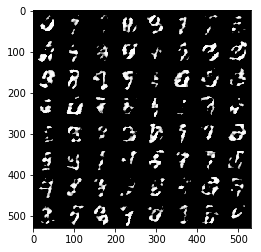

Epoch:  10


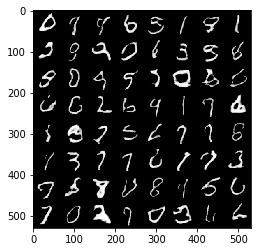

Epoch:  20


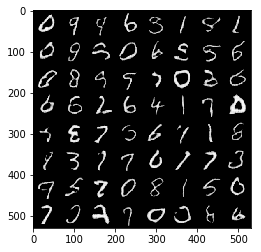

Epoch:  30


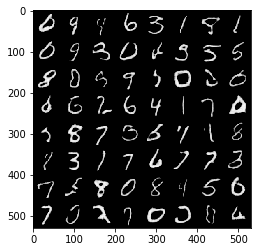

Epoch:  40


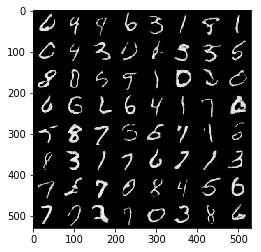

Epoch:  50


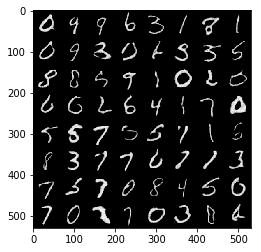

Epoch:  60


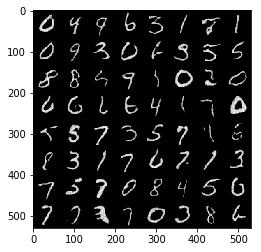

Epoch:  70


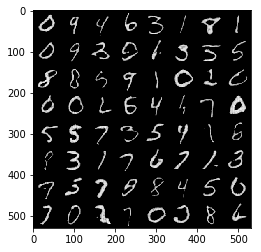

Epoch:  80


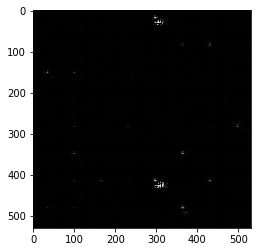

Epoch:  90


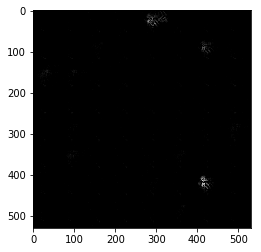

In [20]:
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0,1)

outputDir = 'apresentacao_modelos'
epoch_list = [0,10,20,30,40,50,60,70,80,90]

for epoch in epoch_list:
    load_models(netG,netD,outputDir,epoch)
    output=netG(Variable(fixed_noise))
    vutils.save_image(output.data,'./fake_epoch%s.png'.format(epoch),nrow=8)
    image = mpl.image.imread('./fake_epoch%s.png')
    plt.imshow(image)
    print('Epoch: ',epoch)
    plt.show()

### Predição de classes usando imagens do conjunto de teste

In [23]:
test_sample, test_label = next(iter(dataloader_test))
print("Shape of test samples:", test_sample.size())

test_sample = Variable(test_sample)

output = netD(test_sample)
_, indices = output.max(1)
indices = indices.squeeze().data
count = sum(1 for x in indices if indices[x]==test_label[x])
print("Number of correct predictions:", count)
print(torch.stack((indices, test_label), 1).numpy())

Shape of test samples: torch.Size([64, 1, 64, 64])
Number of correct predictions: 64
[[0 0]
 [4 4]
 [4 4]
 [6 6]
 [2 2]
 [1 1]
 [0 0]
 [6 6]
 [0 0]
 [4 4]
 [8 8]
 [5 5]
 [5 5]
 [1 1]
 [7 7]
 [5 5]
 [1 1]
 [9 9]
 [1 1]
 [1 1]
 [7 7]
 [9 9]
 [1 1]
 [5 5]
 [6 6]
 [7 7]
 [6 6]
 [9 9]
 [9 9]
 [9 9]
 [5 5]
 [2 2]
 [7 7]
 [0 0]
 [4 4]
 [9 9]
 [5 5]
 [5 5]
 [2 2]
 [1 1]
 [1 1]
 [4 4]
 [3 3]
 [4 4]
 [9 9]
 [9 9]
 [3 3]
 [4 4]
 [7 7]
 [2 7]
 [3 3]
 [1 1]
 [5 5]
 [0 0]
 [3 3]
 [8 8]
 [6 6]
 [5 5]
 [6 6]
 [7 7]
 [8 8]
 [5 5]
 [2 2]
 [0 0]]


### Predição de classe para imagens artificiais

In [24]:
test_samples = netG(Variable(fixed_noise))
_, indices = netD(test_samples).max(1)
indices = indices.squeeze().data
count = sum(1 for x in indices if indices[x]==10)
print("Number of correct predictions:", count)
print(indices)

Number of correct predictions: 64

 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
[torch.LongTensor of size 64]



### Imagens Geradas com o modelo DC-GAN
- Qual dos quadrantes contém imagens geradas artificialmente?
- Por que?

<img src='apresentacao_imagens/cherrypick_DCGAN.png', width=500pt>

## Outras referências relevantes

1. https://github.com/soumith/ganhacks
2. https://github.com/pytorch/examples/tree/master/dcgan
3. https://github.com/martinarjovsky/WassersteinGAN